# Addition and adaptation of Myriam's `Feature_selection_for_BRCA.pynb` 
State of the art review and additional Feature selection and visualization methods computation
(by Anaïs)

## State of the art of feature selection methods
### Relevant papers selection
- [Feature Selection: A Review and Comparative Study - 2022](https://www.e3s-conferences.org/articles/e3sconf/pdf/2022/18/e3sconf_icies2022_01046.pdf)
- [A review of feature selection methods with applications - 2015](https://bib.irb.hr/datoteka/763354.MIPRO_2015_JovicBrkicBogunovic.pdf)
- [Feature Selection for Classification: A Review - 2014](https://www.cse.msu.edu/~tangjili/publication/feature_selection_for_classification.pdf)
- [Feature Selection: A Review and Comparative Study - 2022](https://www.e3s-conferences.org/articles/e3sconf/pdf/2022/18/e3sconf_icies2022_01046.pdf)
- [Feature selection methods and genomic big data: a systematic review - 2019](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0241-0) 
- [A Review of Feature Selection Methods for Machine Learning-Based Disease Risk Prediction - 2022](https://www.frontiersin.org/articles/10.3389/fbinf.2022.927312/full)</br> This one also present a nice discussion (we can take inspiration from) on removing redundancy but keeping interesting correlated features (see paragraph: "The Problem of Feature Redundancy and Feature Interaction in SNP Genotype Dataset").

- & Additional ressource (*Myriam*): [Sklearn methods description](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

They provide consistant useful information and summary with pro and cons of each methods.




### In brief 
*Info from the selection, you can look at each paper specific papers for more pro/cons and examples of each method*

Relevant mention before focusing on main methods:</br>
"**Dimensionality reduction** is one of the most popular techniques to remove noisy (i.e. irrelevant) and redundant features. Dimensionality reduction techniques can be categorized mainly into feature extraction and feature selection."</br>
*Examples:* PCA with features contribution score to the first PC, Variance threshold</br>
*Examples genomic work:* Sorting genome

Main strategies to get more discriminative features (for classification/regression):</br>
**3 major method types:**
- **filters** (preprocessing - independant from classifier )
    - *Pro:* fast, scalable, generalizable (more than wrapper), reduce overfitting risk
    - *Con:* not efficient, feature dependencies not modeled (univariate) 
    - *Examples:* 
        - Univariate: Chi-squared test, Fisher's exact test, Pearson correlation, information gain, t-test, Mann-Whitney U test, mutual information
        - Multivariate: Fast correlation-based filter, relief-based algorithms
    - *Examples genomic work:* mRMR, PFBP 

- **Wrappers** (predictive model trained along the selection - include classification performance of the used classifier, such as accuracy, within the evaluation of the feature selection)
    - *Pro:* efficient, take into account interactions between features, identify feature interactions of higher order, better performance than filters, model interaction with classifier
    - *Con:* computationally  expensive (even worse for big dataset) in terms of models complexity and resources requirements, slower than filters and embedded methods, more prone to overfiting, selected features classifier dependent (bias toward modelling algorithm)
    - *Examples:*  Support Vector Machine Recursive Feature Elimination SVM-RFE, Sequential Forward Selection SFS, Sequential forward and backward selection, randomized hill climbing, recursive feature elimination
    - *Examples genomic work:* MINT, Boruta random forrest, MIMIC FS, FIFS

- **Embedded** (do not separate the learning from the feature selection part, conducted and optimized during the classification process)
    - *Pro:* advantages of filters and wrappers= fast and efficient (classify dependencies with less computing difficulty than wrapper), accurate, take into account interaction between features, model feature dependencies, model interaction with classifier
    - *Con:* slower than filter, selected features classifier dependent, learning algorithm specific
    - *Examples:* SVM, LASSO (L1-Regularization) or elastic net regression, Bridge regularization, RIDGE (L2-Regularization), random forest
    - *Examples genomic work:* Random forest Naïve Bayes, Cox-regression (TCGA), mRMR IFS, ROSEFW-RF 

- **Other**: 
	- **hybrid** = multiple consecutive FS methods
	- **ensemble** = aggregate of feature subsets of diverse base classifiers
	- **integrative** = use of external knowledge

**Remarks:**</br>
- *Feature Selection for Classification: A Review* specify that the filter/wrappers/embedded methods work for **flat features** where features are assumed independent. (but, keep in mind that some papers mention the methods can detect features dependencies). We need different methods for structured features like graph (or group or set). It can be used as a **pro for our paper method that works for both flat and graph-structured features**.

- **Sklearn** Recursive feature elimination and Feature selection using SelectFromModel methods seems to be wrappers and embedded methods, difficult to distinguish which is which</br>

## Methods to implement for the paper
- Try the sklearn algorithms quick to implement

- Ideally test at least one dimension reduction, one filter, one wrapper, one embedded
    - One dim reduction method standard: PCA with contribution first PC
    - Filter: Chi-squared test - Fisher test - Pearson correlation - Mutual information
    - Wrapper: ? -- more specific, need development of a model to test subset of features while training -- Maybe SVM can be counted as wrapper too, sklearn methods difficult to distinguish between wrapper and embedded
    - Embedded: Random forest - Lasso 



## Problem running XAI-in-progress code

- Could download the data and run the code
- Could not generate the simulation data (neither SIMU1 nor SIMU2), see error: `

In [ ]:
Genes over-expressed in a group containing about 10.000000000000002 variables have a drawing probability in this group higher than 0.009999999999999998.

Traceback (most recent call last):

  File "/nfs_home/haget/XAI_in_progress/Simulation/Data/get_simu.py", line 32, in <module>

    alpha, eta, beta, proportion, n_gene, n_pathway, n_class, useful_paths, useful_genes = return_parameters(name)

  File "/nfs_home/haget/XAI_in_progress/Simulation/Data/simulate_data.py", line 177, in return_parameters

    eta[P], beta[P] = generate_eta_beta(n_pathway, sparsity, n_gene, case=case)[P]

TypeError: tuple indices must be integers or slices, not str

- Could not run *"Discover_gdc_tcga_gene_expression_data.ipynb"* because of no function ```get_X_y```

## Feature selection implementation

### Librairies

In [3]:
import os
import sys
code_path = os.path.split(os.path.split(os.getcwd())[0])[0]
sys.path.append(code_path)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2, VarianceThreshold
from sklearn.metrics import jaccard_score
from setting import *
from utils import *
from loader import *

set_pyplot()

### Path

In [4]:
name = 'BRCA'  
save_path = get_save_path(name, code_path)
data_path = get_data_path(name)

### Useful functions
[sklearn functions description](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

#### Dimension reduction
1. Variance threshold
2. PCA

In [5]:
# Univariate feature selection
## Without labels
def select_features_with_high_variance(X, threshold):
    """
    Select all features whose variance is higher some threshold.
    """
    alg = VarianceThreshold(threshold=threshold)
    alg.fit(X)
    return alg.variances_

In [6]:
# PCA
# TO CODE

#### Filters
1. Fisher test
2. Mutual information
3. Chi-squared test 
4. Pearson correlation --> No, cf. used for regression and not classification

In [7]:
# Univariate feature selection
## With labels
def select_features_with_F_test(X, y):
    scores, p = f_classif(X, y)
    # assert (np.argsort(scores) == np.argsort(-p)).all()
    return scores

def select_features_with_mutual_information(X, y): 
    return mutual_info_classif(X, y)

def select_features_with_chi2_test(X, y):
    scores, p = chi2(X, y)
    # assert (np.argsort(scores) == np.argsort(-p)).all()
    return scores

#### Wrappers / embedded
1. Recursive feature elimination RFE
2. L1-based 
3. Tree-based


In [8]:
# RFE
# TO CODE

In [9]:
# L1-based
# TO CODE 

In [10]:
# Tree-based 
# TO CODE

### Dataset

In [11]:
# Normalisation of the data
# We assume that the unit of the gene expression is log2(raw count +1).
## If normalize is True, several normalisations are applied to the data.
## 1. The sum of the raw counts per sample is made equal to 10**6.
## 2. The average value of each gene (computed on the training set) is removed from each gene. 
normalize = False

# Load BRCA dataset
X, X_test, y, y_test, n_class, n_feat, class_name, feat_name = load_dataset(data_path, name, normalize)

# For PyTorch only: use load_dataloader to train/test a neural network.
# train_loader, test_loader, n_class, n_feat, class_name, feat_name, transform, n_sample = load_dataloader(data_path, name, device)
# print(f"In our dataset, we have {n_class} classes and {n_sample} examples. Each example contains {n_feat} features.")

In [12]:
print(f"Number of classes: {n_class}.")
print(f"    Classes: {class_name}.")
print(f"Number of genes: {X.shape[1]}.")
print(f"Examples of names: {feat_name[:3]}.")
print(f"Number of training examples: {X.shape[0]}.")
print(f"Number of test examples: {X_test.shape[0]}.")

Number of classes: 2.
    Classes: ['Primary Tumor', 'Solid Tissue Normal'].
Number of genes: 58274.
Examples of names: ['ENSG00000000003.13', 'ENSG00000000005.5', 'ENSG00000000419.11'].
Number of training examples: 726.
Number of test examples: 484.


### Feature selection methods

In [13]:
# Parameter
threshold = 0.1  # for "select_features_with_high_variance" only

# Features ranked by scores by each feature selection method
scores_var = select_features_with_high_variance(X, threshold)
# scores_F = select_features_with_F_test(X, y)
# scores_MI = select_features_with_mutual_information(X, y)
# scores_chi2 = select_features_with_chi2_test(X, y)

In [14]:
# TO COMPLETE WITH NEW METHODS

In [15]:
# Load the features ranked by IG for all BRCA samples
model_name = "MLP"  # "MLP" or "LR"
set_name = "train"
exp = 1  # exp between 1 and 10
scores_IG = np.load(os.path.join("scores", f"{model_name}_{exp}_{set_name}_avg.npy"))

### Overlap between the various models

In [16]:
scores1 = scores_IG.copy()
scores2 = scores_var.copy()

order1 = np.argsort(-scores1)
order2 = np.argsort(-scores2)

In [17]:
# Calculate the Jaccard score between two orders
n_args = [1, 10, 100, 1000, 10000]
avg_jaccard_scores = []

for n in n_args:
    set1 = set(order1[:n])
    set2 = set(order2[:n])
    avg_jaccard_scores.append(len(list(set1.intersection(set2))) / n)

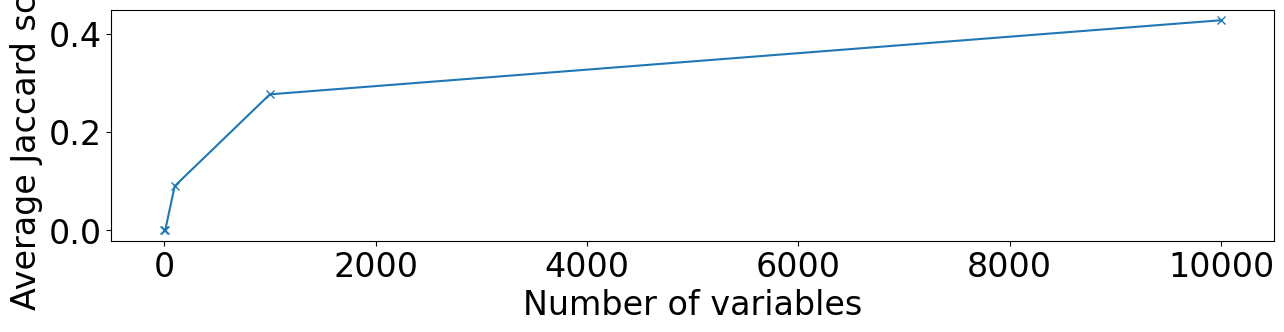

In [18]:
# Show the Jaccard scores
plt.figure(figsize=(15, 3))
plt.plot(n_args, avg_jaccard_scores, 'x-')
plt.xlabel("Number of variables")
plt.ylabel(f"Average Jaccard score")
plt.show()

### Barplots for visual representation of score (dis)similarity for each features

In [19]:
# TO CODE similar to neuroscience brain region code